In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from aegomoku.gomoku_game import ConstantBoardInitializer, GomokuGame
from aegomoku.arena import Arena
from aegomoku.interfaces import MctsParams, PolicyParams
from aegomoku.gomoku_players import PolicyAdvisedGraphSearchPlayer
import tensorflow as tf
tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [3]:
from setup_local import DATA_PATH

BOARD_SIZE = 19

In [32]:
from aegomoku.gomoku_game import RandomBoardInitializer
initializer = RandomBoardInitializer(BOARD_SIZE, 2, 9, 11, 9, 11)

the_game = GomokuGame(board_size=BOARD_SIZE, initializer=initializer)

model_file = DATA_PATH / 'models' / '2_c1.model'
mcts_champion = MctsParams(cpuct=1.0, temperature=0, num_simulations=10)
policy_champion = PolicyParams(model_file_name=model_file, advice_cutoff=.01)
player1 = PolicyAdvisedGraphSearchPlayer("Champion 2_c1", the_game, mcts_champion, policy_champion)

model_file = DATA_PATH / 'models' / '3_c2.model'
mcts_challenger = MctsParams(cpuct=1.0, temperature=0, num_simulations=10)
policy_challenger = PolicyParams(model_file_name=model_file, advice_cutoff=.01)
player2 = PolicyAdvisedGraphSearchPlayer("Candidate 3_c2", the_game, mcts_challenger, policy_challenger)

arena = Arena(game=the_game, player1=player1, player2=player2, max_moves=4)

In [33]:
arena.play_game(verbose=2)

Champion 2_c1 to begin with black.
1: Champion 2_c1: K7
2: Candidate 3_c2: N10
3: Champion 2_c1: J6
4: Candidate 3_c2: K9
Draw after 4 moves.


# TODO: Arena needs to respect the gamestate

In [34]:
arena.board.plot()

                                                                 
19    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
18    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
17    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
16    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
15    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
14    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
13    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
12    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
11    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
10    .  .  .  .  .  .  .  .  .  .  .  .  .  O  .  .  .  .  .    
 9    .  .  .  .  .  .  .  .  .  . [O] .  .  .  .  .  .  .  .    
 8    .  .  .  .  .  .  .  .  .  O  .  X  .  .  .  .  .  .  .    
 7    .  .  .  .  .  .  .  .  .  .  X  .  .  .  .  .  .  .  .    
 6    .  .  .  .  .  .  .  .  .  X  .  .  .  .  .  .  .  .  .    
 5    .  .

In [35]:
arena_file = DATA_PATH / 'arena' / '3_c2.arena'

In [36]:
stats = arena.play_games(2, verbose=1, save_to=arena_file)

Game 1: Champion 2_c1 to begin with black.
Draw after 4 moves.
[L8, J9, M9, I8, K7, J6]
Game 2: Candidate 3_c2 to begin with black.
Draw after 4 moves.
[L8, J8, K7, L10, K9, K8]
Saved gameplay data to /Users/wgiersche/workspace/Project-Ellie/DeepGomoku/DATA/arena/3_c2.arena


In [37]:
stats

{Champion 2_c1: 0, Candidate 3_c2: 0, 'draws': 2}

In [38]:
n=0

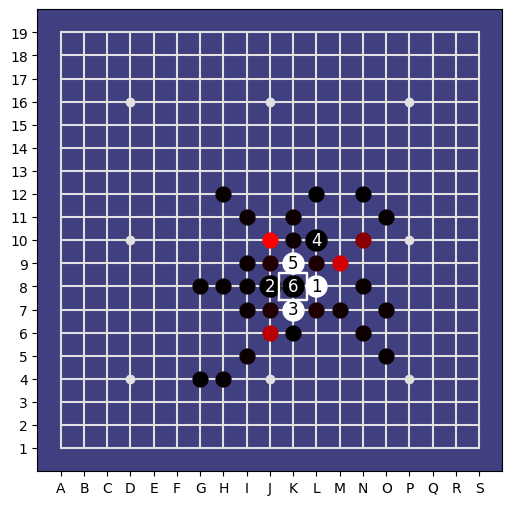

In [40]:
from aegomoku.utils import analyse_board
moves = arena.board.stones
from aegomoku.policies.topological_value import TopologicalValuePolicy

policy = TopologicalValuePolicy(board_size=19)

analyse_board(BOARD_SIZE, arena.games[n], policy, disp_width=6)
n += 1